In [0]:
spark

In [0]:
table = "dmp-424607.retail.fct_invoices"
df = spark.read.format("bigquery").option("table",table).load()
df.createOrReplaceTempView("retail")

In [0]:
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col

timeFmt = "MM/dd/yy HH:mm"

df = df.withColumn('NewInvoiceDate'
                 , to_utc_timestamp(unix_timestamp(col('datetime_id'),timeFmt).cast('timestamp')
                 , 'UTC'))


In [0]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df.show(5)

+----------+-------------+--------------------+--------------------+--------+------------------+-------------------+
|invoice_id|  datetime_id|          product_id|         customer_id|quantity|             total|     NewInvoiceDate|
+----------+-------------+--------------------+--------------------+--------+------------------+-------------------+
|    552835|5/11/11 14:17|e2b8e5777ea4d9caa...|0010ca63306443631...|      24| 6.959999999999999|2011-05-11 14:17:00|
|    552835|5/11/11 14:17|4d73a3f9193fa4f98...|0010ca63306443631...|      24|13.200000000000001|2011-05-11 14:17:00|
|    552835|5/11/11 14:17|17df8a65718e4d345...|0010ca63306443631...|      25|              10.5|2011-05-11 14:17:00|
|    552835|5/11/11 14:17|500b02f3b8507cbed...|0010ca63306443631...|       6|15.299999999999999|2011-05-11 14:17:00|
|    552835|5/11/11 14:17|f7e8e0854ccd8f718...|0010ca63306443631...|       6|15.299999999999999|2011-05-11 14:17:00|
+----------+-------------+--------------------+-----------------

In [0]:
from pyspark.sql.functions import mean, min, sum, datediff, to_date
from pyspark.sql.functions import max as spark_max
date_max = df.select(spark_max('NewInvoiceDate')).toPandas()
current = to_utc_timestamp( unix_timestamp(lit(str(date_max.iloc[0][0])), \
                              'yy-MM-dd HH:mm').cast('timestamp'), 'UTC' )

# Calculatre Duration
df = df.withColumn('Duration', datediff(lit(current), 'NewInvoiceDate'))

In [0]:
from pyspark.sql.functions import count, min, sum, round
recency = df.groupBy('customer_id').agg(min('Duration').alias('Recency'))
frequency = df.groupBy('customer_id', 'invoice_id').count()\
                        .groupBy('customer_id')\
                        .agg(count("*").alias("Frequency"))
monetary = df.groupBy('customer_id').agg(round(sum('total'), 2).alias('Monetary'))
rfm = recency.join(frequency,'customer_id', how = 'inner')\
             .join(monetary,'customer_id', how = 'inner')

In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
rfm_col = ["Recency", "Frequency", "Monetary"]
assembler = VectorAssembler().setHandleInvalid("skip").setInputCols(rfm_col).setOutputCol("unscaled_features")
scaler = StandardScaler().setInputCol("unscaled_features").setOutputCol("features")

In [0]:
from pyspark.ml import Pipeline
# create and fit pipeline model
pipeline_obj = Pipeline().setStages([assembler, scaler])
pipeline_model = pipeline_obj.fit(rfm)

In [0]:
# show transform pipeline dataframe
transform_df = pipeline_model.transform(rfm)
transform_df.limit(5).toPandas()

,customer_id,Recency,Frequency,Monetary,unscaled_features,features
0,19e1746685ef1f075af6b6b4e8a08994,196,1,3096.00,"[196.0, 1.0, 3096.0]","[1.9577446320327865, 0.13001765974128188, 0.34..."
1,2490148d30e0861311050c80a10977d0,3,1,336.43,"[3.0, 1.0, 336.43]","[0.029965479061726325, 0.13001765974128188, 0...."
2,579921a20f09fab15d305efb4f548f5a,52,5,1253.36,"[52.0, 5.0, 1253.36]","[0.5194016370699229, 0.6500882987064094, 0.139..."
3,617bfc5051740e86d7986420b918cae8,43,2,657.30,"[43.0, 2.0, 657.3]","[0.429505199884744, 0.26003531948256375, 0.073..."
4,6589921c988c3649b7782511cea57282,39,1,243.94,"[39.0, 1.0, 243.94]","[0.3895512278024422, 0.13001765974128188, 0.02..."


In [0]:
from pyspark.ml.clustering import KMeans
# compute k-means model for k clusters
def compute_kmeans_model(dataframe, k):
    kmeans_object = KMeans() \
        .setSeed(123) \
        .setK(k)
    
    return kmeans_object.fit(dataframe)
    

In [0]:

from pyspark.ml.evaluation import ClusteringEvaluator
# create evaluator object
evaluator = ClusteringEvaluator()

In [0]:
# find optimum k 
def find_optimum_k(transform_df, k_range):
    score_k_list = []
    for k in range(2, k_range):
        kmeans_model = compute_kmeans_model(transform_df, k)
        transformed_df = kmeans_model.transform(transform_df)
        score_k = evaluator.evaluate(transformed_df)
        score_k_list.append(score_k)
    optimum_k_value = max(score_k_list)
    optimum_k_index = score_k_list.index(optimum_k_value) + 2
    print("Optimum k value: {:.3f} , and index: {}".format(optimum_k_value, optimum_k_index))
    return optimum_k_index

In [0]:
optimum_k = find_optimum_k(transform_df, 6)

Optimum k value: 0.783 , and index: 4


In [0]:
kmeans_model = compute_kmeans_model(transform_df, optimum_k)

In [0]:
# prediction
transformed_df = kmeans_model.transform(transform_df)
# Drop 'unscaled_features' and 'features' columns
df_pred = transformed_df.drop('unscaled_features', 'features')

# Show the first 5 rows
df_pred.limit(5).toPandas()

,customer_id,Recency,Frequency,Monetary,prediction
0,19e1746685ef1f075af6b6b4e8a08994,196,1,3096.00,0
1,2490148d30e0861311050c80a10977d0,3,1,336.43,1
2,579921a20f09fab15d305efb4f548f5a,52,5,1253.36,1
3,617bfc5051740e86d7986420b918cae8,43,2,657.30,1
4,6589921c988c3649b7782511cea57282,39,1,243.94,1


In [0]:
# Lưu mô hình KMeans vào đường dẫn trên DBFS (Databricks File System)
model_path = "/mnt/models/kmeans_model"
kmeans_model.write().overwrite().save(model_path)

In [0]:
from pyspark.sql.functions import col, when

# Tính quantiles cho Recency
recency_quantiles = df_pred.approxQuantile("Recency", [0.2, 0.4, 0.6, 0.8], 0)

# Gán nhãn cho Recency
df_pred = df_pred.withColumn("Recency_score", 
                   when(col("Recency") <= recency_quantiles[0], 5)
                   .when((col("Recency") > recency_quantiles[0]) & (col("Recency") <= recency_quantiles[1]), 4)
                   .when((col("Recency") > recency_quantiles[1]) & (col("Recency") <= recency_quantiles[2]), 3)
                   .when((col("Recency") > recency_quantiles[2]) & (col("Recency") <= recency_quantiles[3]), 2)
                   .otherwise(1))

# Tính quantiles cho Frequency
frequency_quantiles = df_pred.approxQuantile("Frequency", [0.2, 0.4, 0.6, 0.8], 0)

# Gán nhãn cho Frequency
df_pred = df_pred.withColumn("Frequency_score", 
                   when(col("Frequency") <= frequency_quantiles[0], 1)
                   .when((col("Frequency") > frequency_quantiles[0]) & (col("Frequency") <= frequency_quantiles[1]), 2)
                   .when((col("Frequency") > frequency_quantiles[1]) & (col("Frequency") <= frequency_quantiles[2]), 3)
                   .when((col("Frequency") > frequency_quantiles[2]) & (col("Frequency") <= frequency_quantiles[3]), 4)
                   .otherwise(5))

monetary_quantiles = df_pred.approxQuantile("Monetary", [0.2, 0.4, 0.6, 0.8], 0)
df_pred = df_pred.withColumn("Monetary_score", 
                   when(col("Monetary") <= monetary_quantiles[0], 1)
                   .when((col("Monetary") > monetary_quantiles[0]) & (col("Monetary") <= monetary_quantiles[1]), 2)
                   .when((col("Monetary") > monetary_quantiles[1]) & (col("Monetary") <= monetary_quantiles[2]), 3)
                   .when((col("Monetary") > monetary_quantiles[2]) & (col("Monetary") <= monetary_quantiles[3]), 4)
                   .otherwise(5))
                   
df_pred.limit(5).toPandas()

,customer_id,Recency,Frequency,Monetary,prediction,Recency_score,Frequency_score,Monetary_score
0,19e1746685ef1f075af6b6b4e8a08994,196,1,3096.00,0,1,1,5
1,2490148d30e0861311050c80a10977d0,3,1,336.43,1,5,1,2
2,579921a20f09fab15d305efb4f548f5a,52,5,1253.36,1,3,4,4
3,617bfc5051740e86d7986420b918cae8,43,2,657.30,1,3,2,3
4,6589921c988c3649b7782511cea57282,39,1,243.94,1,3,1,1


In [0]:
from pyspark.sql.functions import concat, col

df_pred = df_pred.withColumn("RFM_Score", 
                                           concat(col("Recency_score").cast("string"), 
                                                  col("Frequency_score").cast("string"),
                                                  col("Monetary_score").cast("string")))


In [0]:
from pyspark.sql import functions as F

df_pred = df_pred.withColumn(
    "Segment",
    F.when(F.col("RFM_Score").isin(['555', '554', '544', '545', '454', '455', '445']), 'Champion')
    .when(F.col("RFM_Score").isin(['543', '444', '435', '355', '354', '345', '344', '335']), 'Loyal Customer')
    .when(F.col("RFM_Score").isin(['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323']), 'Potential Loyalist')
    .when(F.col("RFM_Score").isin(['512', '511', '422', '421', '412', '411', '311']), 'New Customer')
    .when(F.col("RFM_Score").isin(['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313']), 'Promising')
    .when(F.col("RFM_Score").isin(['535', '534', '443', '434', '343', '334', '325', '324']), 'Need Attention')
    .when(F.col("RFM_Score").isin(['155', '154', '144', '214', '215', '115', '114', '113']), 'Cannot Lose Them')
    .when(F.col("RFM_Score").isin(['331', '321', '312', '221', '213']), 'About To Sleep')
    .when(F.col("RFM_Score").isin(['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124']), 'At Risk')
    .when(F.col("RFM_Score").isin(['332', '322', '231', '241', '251', '233', '232', '223', '222', '132', '123', '122', '212', '211']), 'Hibernating')
    .when(F.col("RFM_Score").isin(['111', '112', '121', '131', '141', '151']), 'Lost')
)
df_pred = df_pred.drop('Recency_score', 'Frequency_score', 'Monetary_score', 'RFM_Score')
df_pred.limit(5).toPandas()

,customer_id,Recency,Frequency,Monetary,prediction,Segment
0,dd21a1ac6583288dc42a57b6dd5c49db,3,38,9817.12,2,Champion
1,579921a20f09fab15d305efb4f548f5a,52,5,1253.36,1,Loyal Customer
2,9092a59ca5d4644fece2f834b2429f1d,185,6,683.46,0,At Risk
3,8885a449cd731b2a0558ca96fa580cb3,51,2,2093.32,1,Need Attention
4,eb69b66205e6446d16d6b2b9f9c47ab4,2,21,6363.59,2,Champion


In [0]:
# Chuyển đổi DataFrame Spark thành Pandas DataFrame
pandas_df = df_pred.toPandas()

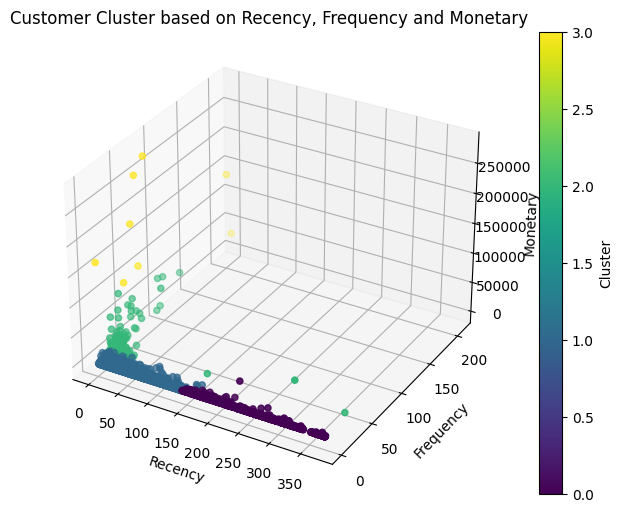

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Create a dictionary to map categories to numbers
category_dict = {category: i for i, category in enumerate(np.unique(pandas_df['Segment']))}

# Create a new column in your DataFrame that maps the 'rfm_segment' values to numbers
pandas_df['rfm_segment_num'] = pandas_df['Segment'].map(category_dict)

# Now use 'rfm_segment_num' for color argument in scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pandas_df['Recency'], pandas_df['Frequency'], pandas_df['Monetary'], 
                     c=pandas_df['prediction'], cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

ax.set_title('Customer Cluster based on Recency, Frequency and Monetary')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

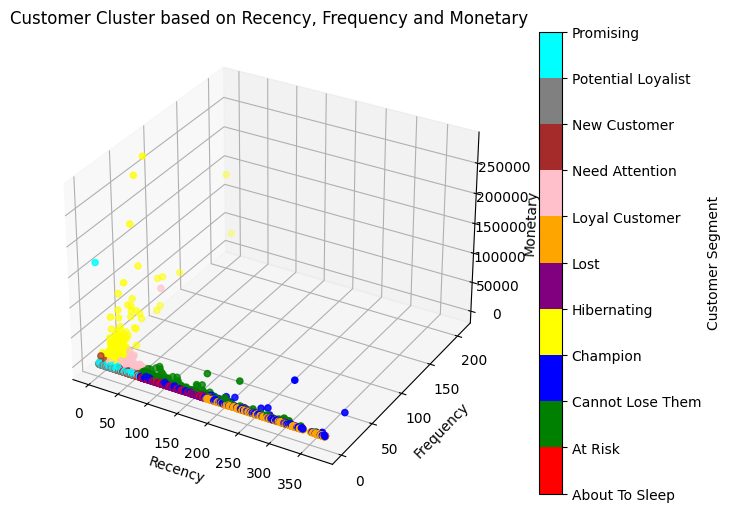

In [0]:
from matplotlib.colors import ListedColormap

# Create a colormap
cmap = ListedColormap(['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan'])

# Create a dictionary to map categories to numbers
category_dict = {category: i for i, category in enumerate(np.unique(pandas_df['Segment']))}

# Create a new column in your DataFrame that maps the 'rfm_segment' values to numbers
pandas_df['rfm_segment_num'] = pandas_df['Segment'].map(category_dict)

# Now use 'rfm_segment_num' for color argument in scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pandas_df['Recency'], pandas_df['Frequency'], pandas_df['Monetary'], 
                     c=pandas_df['rfm_segment_num'], cmap=cmap)

# Add a colorbar with the unique labels
cbar = plt.colorbar(scatter, ticks=np.arange(len(category_dict)))
cbar.set_label('Customer Segment')
cbar.set_ticklabels(list(category_dict.keys()))

ax.set_title('Customer Cluster based on Recency, Frequency and Monetary')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

In [0]:
summary_pd = df_pred.groupBy('prediction').agg(
    F.avg(df_pred['Recency']).alias('Avg_Recency'),
    F.avg(df_pred['Frequency']).alias('Avg_Frequency'),
    F.avg(df_pred['Monetary']).alias('Avg_Monetary'),
).orderBy('prediction').toPandas()

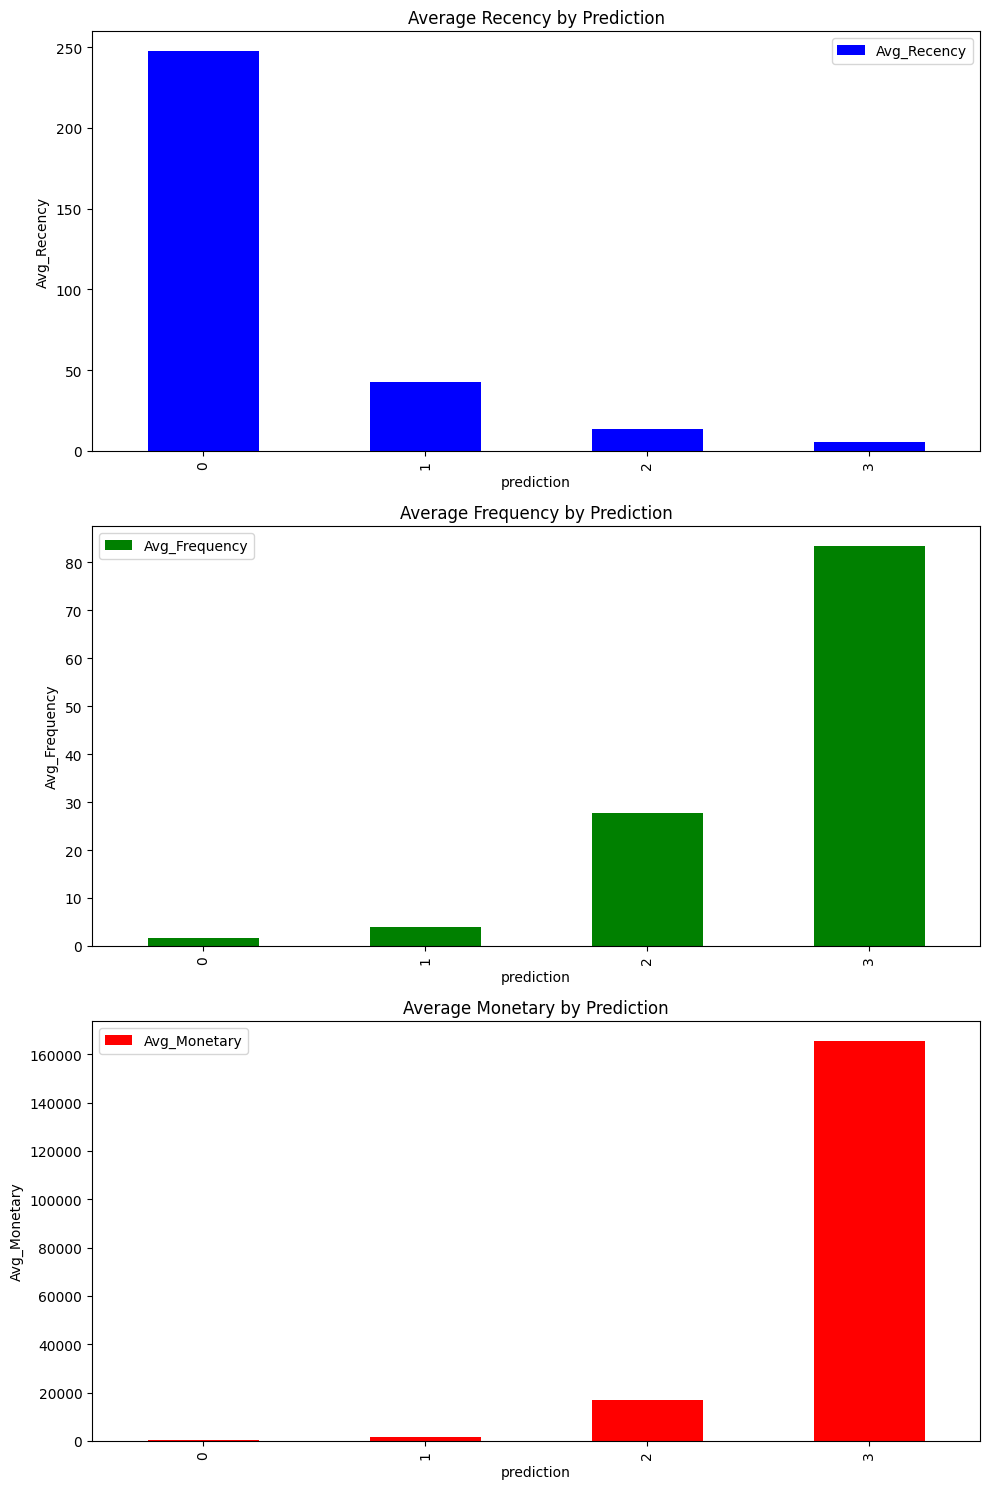

In [0]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

summary_pd.plot(x='prediction', y='Avg_Recency', kind='bar', ax=axs[0], color='blue')
axs[0].set_title('Average Recency by Prediction')
axs[0].set_ylabel('Avg_Recency')

# Plot Avg_Frequency
summary_pd.plot(x='prediction', y='Avg_Frequency', kind='bar', ax=axs[1], color='green')
axs[1].set_title('Average Frequency by Prediction')
axs[1].set_ylabel('Avg_Frequency')

# Plot Avg_Monetary
summary_pd.plot(x='prediction', y='Avg_Monetary', kind='bar', ax=axs[2], color='red')
axs[2].set_title('Average Monetary by Prediction')
axs[2].set_ylabel('Avg_Monetary')

plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import create_map, lit
from itertools import chain

# Create a dictionary with the old and new values
prediction_labels = {0: 'Khách hàng nguy cơ', 1: 'Khách hàng mới', 2: 'Khách hàng tiềm năng', 3: 'Khách hàng VIP'}

# Convert the dictionary to a map
mapping_expr = create_map([lit(x) for x in chain(*prediction_labels.items())])

# Replace the values in the 'prediction' column
df_segment = df_pred.withColumn('prediction', mapping_expr[df_pred['prediction']])

df_segment.limit(5).show()

+--------------------+-------+---------+--------+--------------------+--------------+
|         customer_id|Recency|Frequency|Monetary|          prediction|       Segment|
+--------------------+-------+---------+--------+--------------------+--------------+
|dd21a1ac6583288dc...|      3|       38| 9817.12|Khách hàng tiềm năng|      Champion|
|579921a20f09fab15...|     52|        5| 1253.36|      Khách hàng mới|Loyal Customer|
|9092a59ca5d4644fe...|    185|        6|  683.46|  Khách hàng nguy cơ|       At Risk|
|8885a449cd731b2a0...|     51|        2| 2093.32|      Khách hàng mới|Need Attention|
|eb69b66205e6446d1...|      2|       21| 6363.59|Khách hàng tiềm năng|      Champion|
+--------------------+-------+---------+--------+--------------------+--------------+



In [0]:
# Định nghĩa thông tin BigQuery
project_id = "dmp-424607"
dataset_id = "spark_data_load"
table_id = "rfm_customer"
gcs_bucket = "bucket_online_retail_dmp"  # replace with your GCS bucket name


try:
    # Save DataFrame to BigQuery
    df_segment.write.format('bigquery') \
      .option('table', f"{project_id}.{dataset_id}.{table_id}") \
      .option("temporaryGcsBucket", gcs_bucket) \
      .mode('overwrite') \
      .save()
except Exception as e:
    print(str(e))